# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import permutations
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import tdqm

# magic word for producing visualizations in notebook
%matplotlib inline

# allow autocomplete for easier typing
%config IPCompleter.greedy=True

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
feat_info.shape

(85, 4)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# sense check replacements
print(pd.value_counts(azdias['CAMEO_INTL_2015'] == 'XX'))

print(pd.value_counts(azdias['ALTERSKATEGORIE_GROB'] == 9))

False    890848
True        373
Name: CAMEO_INTL_2015, dtype: int64
False    888340
True       2881
Name: ALTERSKATEGORIE_GROB, dtype: int64


In [8]:
# Identify missing or unknown data values and convert them to NaNs.

# sudo-code
# for each row in feat_info
    # parse the values of missing_or_unknown based on the type (e.g. to int if ordinal etc.)

actually_nan_count = azdias.isnull().sum()
    
missing_value_dict = {}    
for idx, row in feat_info.iterrows():
    
    missing_list_raw = row.missing_or_unknown.strip('][').split(',')
    
    missing_list_converted = []
    for entry in missing_list_raw:
        # try convert to int
        try:
            missing_list_converted.append(int(entry))
        except:
            missing_list_converted.append(entry)

    missing_value_dict[row.attribute] = missing_list_converted

# sudo-code
# use dictionary of missing values for each column
# loop over each column
    # loop over each missing value for that column
        # replace the missing value with NaN
        
for column in azdias.columns:
    for missing_value in missing_value_dict[column]:
#         print('Replacing {} with NaN, in column {}'.format(missing_value, column))
        azdias[column].replace(missing_value, np.NaN, inplace=True)

after_1st_clean_nan_count = azdias.isnull().sum()



In [9]:
# sense check replacements
print(pd.value_counts(azdias['CAMEO_INTL_2015'] == 'XX'))
print(pd.value_counts(azdias['ALTERSKATEGORIE_GROB'] == 9))


False    891221
Name: CAMEO_INTL_2015, dtype: int64
False    891221
Name: ALTERSKATEGORIE_GROB, dtype: int64


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

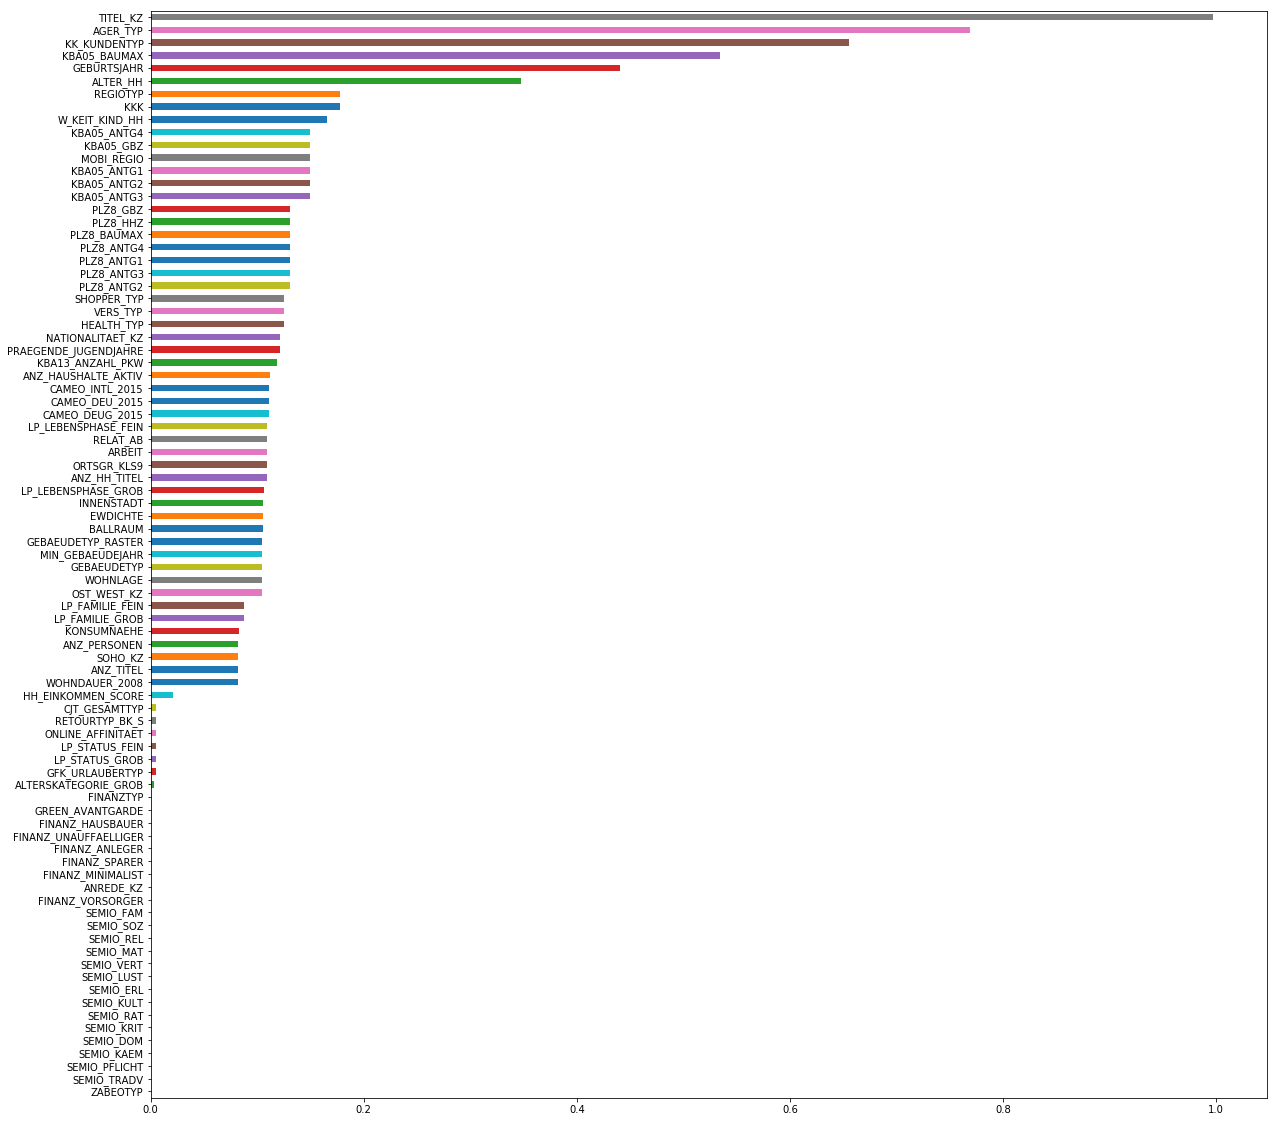

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# hist was difficult as theres too many columns to sift through 
# so using barh instead
prop_missing = azdias.isnull().sum()/azdias.isnull().count()
prop_missing.sort_values().plot(kind='barh', figsize=(20,20))
plt.show()

In [11]:
# Investigate patterns in the amount of missing data in each column.

# it appears that there is a set of columns that are all missing data in the same proportions
pd.value_counts(prop_missing).sort_values()

# lets make a grid where it measures a kind of 'conditional' null count
# i.e. proportion of nulls in X when Y is null
# TODO see if theres a faster way to do this
# conditional_null_list = []
# for x, y in permutations(prop_missing[prop_missing != 0].index.tolist(), 2):
#     conditional_null = azdias[azdias[y].isnull()][x].isnull().mean() 
#     conditional_null_list.append((x, y, conditional_null))



0.109147     1
0.104525     1
0.003233     1
0.121366     1
0.109549     1
0.020587     1
0.348137     1
0.655967     1
0.166051     1
0.534687     1
0.121536     1
0.106115     1
0.118714     1
0.997576     1
0.108848     1
0.769554     1
0.440203     1
0.082997     1
0.111769     1
0.109260     2
0.087287     2
0.177357     2
0.124768     3
0.111479     3
0.105182     3
0.104517     4
0.082470     4
0.005446     6
0.149597     6
0.130736     7
0.000000    24
dtype: int64

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print(prop_missing[prop_missing > .20].index.tolist())

removed_columns = prop_missing[prop_missing > .20].index.tolist()

# lets drop all columns where > 20% of the data is null
azdias = azdias.drop(removed_columns, axis=1, inplace=False)
            

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [13]:
prop_missing[prop_missing > 0].sort_values()

ALTERSKATEGORIE_GROB     0.003233
CJT_GESAMTTYP            0.005446
GFK_URLAUBERTYP          0.005446
ONLINE_AFFINITAET        0.005446
RETOURTYP_BK_S           0.005446
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
HH_EINKOMMEN_SCORE       0.020587
ANZ_PERSONEN             0.082470
SOHO_KZ                  0.082470
ANZ_TITEL                0.082470
WOHNDAUER_2008           0.082470
KONSUMNAEHE              0.082997
LP_FAMILIE_GROB          0.087287
LP_FAMILIE_FEIN          0.087287
GEBAEUDETYP              0.104517
WOHNLAGE                 0.104517
OST_WEST_KZ              0.104517
MIN_GEBAEUDEJAHR         0.104517
GEBAEUDETYP_RASTER       0.104525
EWDICHTE                 0.105182
BALLRAUM                 0.105182
INNENSTADT               0.105182
LP_LEBENSPHASE_GROB      0.106115
ANZ_HH_TITEL             0.108848
ORTSGR_KLS9              0.109147
ARBEIT                   0.109260
RELAT_AB                 0.109260
LP_LEBENSPHASE_FEIN      0.109549
CAMEO_DEUG_201

#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of the 85 columns 61 had atleast 1 entry with missing data

There were 6 columns that had over 20% missing data.

From looking at data more closely, there were alot of columns that had the exact same proportion of missing values.
Looking at these columns together, you can see that when the data is missing in column, its always missing in the other and vice versa.

The columns: 

PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG1
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ

are an example of this. whenever one column has missing data, the other columns have missing data for the exact same entry, exclusively.

From reading the data dictionary and some light googling, it appears that PLZ8 is a large post code region in the south of Germany, around Munich.

The customer data relates to home ownership levels within that post code so it makes sense that if they don't have data about 1 particular aspect of home ownership in that region, they likely don't know anything about other aspects of home ownership their.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
missing_row_data_ratios = azdias.isnull().sum(axis=1)/azdias.shape[1]

df = pd.value_counts(missing_row_data_ratios)/azdias.shape[0]
prop_of_missing_row_data_ratios = pd.DataFrame(df).reset_index()
prop_of_missing_row_data_ratios.columns = ['Ratio Of Missing Data', 'Proportion Of Customers']
# sns.countplot(missing_row_data_ratios)

# ~70% of customers aren't missing any data at all.
# then 5% of customers are missing nearly 60% of the data
prop_of_missing_row_data_ratios.head()


,Ratio Of Missing Data,Proportion Of Customers
0,0.000000,0.699275
1,0.594937,0.051141
2,0.025316,0.031335
3,0.544304,0.030710
4,0.101266,0.027594


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# this is how to split the data
azdias_fullinfo = azdias.loc[missing_row_data_ratios == 0]
azdias_partialinfo = azdias.loc[missing_row_data_ratios != 0]

# but its easier just to add a new bool column that identifies each row as such and keeping it as a single DataFrame
azdias['AllDataPresent'] = missing_row_data_ratios == 0


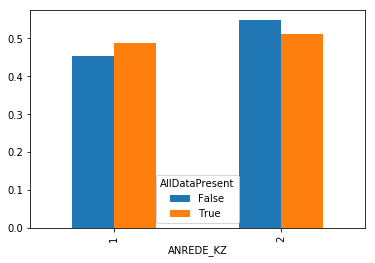

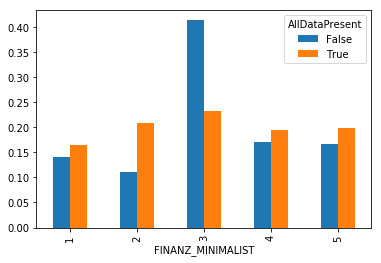

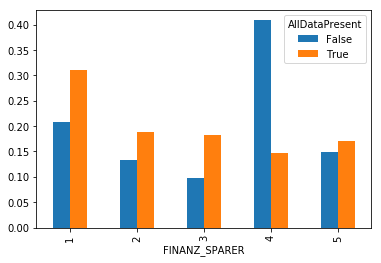

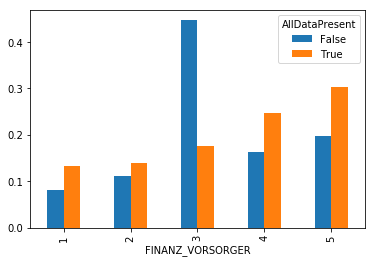

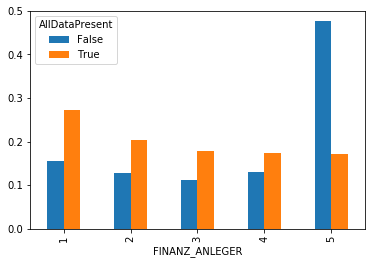

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_with_no_missing_values = prop_missing[prop_missing == 0].index

# graph the 2 types together in one figure for easier comparison
for column in columns_with_no_missing_values[:5]:
    data_present_grouping = azdias[[column, 'AllDataPresent']].groupby('AllDataPresent')
    data_present_grouping[column].value_counts(normalize=True).unstack(0).plot.bar()


In [17]:
azdias.drop('AllDataPresent', axis=1, inplace=True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

when splitting customers up into cases where all customer data is present and cases where there is partially missing data,
its noted that the distribution of values for some columns is very different

for example, for column FINANZ_ANLEGER, which signifies how likely they are to be an 'investor' type customer, with 1 being very high and 5 being very low.

For customers that we have full data on, the proportion of customers that are 5 (very low) is  < 20%, but for customers that we only have partial information on, this proportion is nearly 50%.

it would seem that the data with lots of missing values are qualitatively different from data with no missing values.

this is very important if we decide to remove customers with missing values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
pd.value_counts(feat_info.type)


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_columns = feat_info[feat_info.type == 'categorical'].attribute
# remove the columns that are no longer in the data set due to excess missing data
categorical_columns = categorical_columns[~categorical_columns.isin(removed_columns)]

# count number of unique values
unique_value_counts = azdias_fullinfo[categorical_columns].nunique(axis=0) 

# determine which columsn have a numeric dtype
is_numeric_dict = {}
for column in categorical_columns:
    is_numeric_dict[column] = is_numeric_dtype(azdias_fullinfo[column])
    
encode_options = pd.concat([unique_value_counts, pd.Series(is_numeric_dict)], axis=1)
encode_options.columns = ['UniqueValues', 'Numerical']

# encode types by column
# A = binary, numeric = no re-encoding needed
# B = binary, non-numeric = map to numeric
# C = everything else, One-Hot-Encode

encode_type_dict = {}
for label, row_series in encode_options.iterrows():
    if row_series.UniqueValues == 2 and row_series.Numerical == True:
        encode_type_dict[label] = 'A'
    elif row_series.UniqueValues == 2 and row_series.Numerical == False:
        encode_type_dict[label] = 'B'
    else:
        encode_type_dict[label] = 'C'
        
encode_options = pd.concat([encode_options, pd.Series(encode_type_dict, name="EncodeType")], axis=1)   

encode_options.sort_values(by=['EncodeType'])

,UniqueValues,Numerical,EncodeType
ANREDE_KZ,2,True,A
GREEN_AVANTGARDE,2,True,A
VERS_TYP,2,True,A
SOHO_KZ,2,True,A
OST_WEST_KZ,2,False,B
GEBAEUDETYP,4,True,C
ZABEOTYP,6,True,C
SHOPPER_TYP,4,True,C
NATIONALITAET_KZ,3,True,C
LP_STATUS_GROB,5,True,C


In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.

# encode types by column
# A = binary, numeric = no re-encoding needed
# B = binary, non-numeric = map to numeric
# C = everything else, One-Hot-Encode

# make this a new Dataframe, and not a copy of the previous raw data
# make sure to reindex the index as this will cause problems later if you try to concat any other data to it
azdias_fullinfo = pd.DataFrame(azdias.loc[missing_row_data_ratios == 0])
azdias_fullinfo.reset_index(drop=True, inplace=True)

# OST_WEST_KZ is the only column in type B, so lets map this to numeric
print('Unique Values for OST_WEST_KZ: {}'.format(pd.unique(azdias_fullinfo['OST_WEST_KZ'])))
azdias_fullinfo['OST_WEST_KZ'] = azdias_fullinfo['OST_WEST_KZ'].map({'W': 1, 'O': 0})
print('Unique Values for OST_WEST_KZ: {}'.format(pd.unique(azdias_fullinfo['OST_WEST_KZ'])))

# Now type C
multi_level_cat_columns = encode_options[encode_options.EncodeType == 'C'].index

# Label encode all categories 1st, as one hot encode only works with numerical, not strings
le = LabelEncoder()
for column in multi_level_cat_columns:
    le = le.fit(azdias_fullinfo[column].values)
    azdias_fullinfo[column] = le.transform(azdias_fullinfo[column].values)

# one hot encode labels    
encoder = OneHotEncoder().fit(azdias_fullinfo[multi_level_cat_columns])
transformed_multi_cat_np = encoder.transform(azdias_fullinfo[multi_level_cat_columns]).toarray()

# create column names for new columns
encode_column_names = []
for column in multi_level_cat_columns:
    unique_value_count = pd.unique(azdias_fullinfo[column]).shape[0]
    for i in range(1, unique_value_count+1):
        encode_column_names.append(column + '_' + str(i))

transformed_multi_cat_df = pd.DataFrame(transformed_multi_cat_np, columns=encode_column_names)

Unique Values for OST_WEST_KZ: ['W' 'O']
Unique Values for OST_WEST_KZ: [1 0]


In [21]:
# sense check for onehotencoder
# count of unique values in columns should == count of new columns created
if encode_options[encode_options.EncodeType == 'C'].UniqueValues.sum() == transformed_multi_cat_df.shape[1]:
    print('Sense check passed!')
else:
    print('Sense check failed! :(')
    


Sense check passed!


In [22]:
# concat new columns onto data    
azdias_fullinfo = pd.concat([azdias_fullinfo, transformed_multi_cat_df], axis=1) 

In [23]:
# drop old columns
azdias_fullinfo.drop(multi_level_cat_columns.values, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

1st, I analysed the unique values and data types of each 'categorical' type column.

There were 4 columns that only held 2 values and were of numeric type, so we could leave them as is, as they would effectively act as a binary field.

There was 1 column that held 2 unique string values, OST_WEST_KZ. These string values were mapped to binary

Finally, there were 13 columns that held multiple, string values within each column.

Using the LabelBinarizer() class from sklearn, these strings were convered to numbers
and then using OneHotEncoder() class, these numbers were each represented by their own binary column.

I decided to keep all the columns for now and did not drop any. I can continue with the analysis and if there are bottle necks or its particularly slow, i may come back and drop some.

There is one feature, CAMEO_DEU_2015, that has 44 unique values, so that would probably be a good candidate to drop


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_fullinfo['PRAEGENDE_JUGENDJAHRE'].head()

# for the dict, we'll say mainstream is 0 and avantgard is 1
movement_dict = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0, 2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}
generation_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

azdias_fullinfo['MovementType'] = azdias_fullinfo['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
azdias_fullinfo['AgeGeneration'] = azdias_fullinfo['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)

azdias_fullinfo.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

#sense check
if np.any(azdias_fullinfo[['MovementType', 'AgeGeneration']].isnull().sum() > 0):
    print('Somethings not right. There are nans in the data')
else:
    print('Sense Check passed')
    


Sense Check passed


In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_fullinfo['LifeStage'] = azdias_fullinfo['CAMEO_INTL_2015'].astype(int).mod(10)
azdias_fullinfo['WealthType'] = ((azdias_fullinfo['CAMEO_INTL_2015'].astype(int)-azdias_fullinfo['CAMEO_INTL_2015'].astype(int).mod(10))/10).astype(int)

if np.any(azdias_fullinfo['CAMEO_INTL_2015'].astype(int) != (azdias_fullinfo['WealthType']*10 + azdias_fullinfo['LifeStage']).astype(int)):
    print('Sense check failed!')
else:
    print('Sense check passed!')

azdias_fullinfo.drop('CAMEO_INTL_2015', axis=1, inplace=True)

Sense check passed!


#### Discussion 1.2.2: Engineer Mixed-Type Features

the data within PRAEGENDE_JUGENDJAHRE was split into MovementType & AgeGeneration. the original field was then dropped.
the data within CAMEO_INTL_2015 was split into LifeStage & WealthType. the original field was then dropped.

the new fields were either binary or ordinal so no further transformations were performed

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [26]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [27]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_value_dict = {'AGER_TYP': [-1, 0],
                         'ALTERSKATEGORIE_GROB': [-1, 0, 9],
                         'ANREDE_KZ': [-1, 0],
                         'CJT_GESAMTTYP': [0],
                         'FINANZ_MINIMALIST': [-1],
                         'FINANZ_SPARER': [-1],
                         'FINANZ_VORSORGER': [-1],
                         'FINANZ_ANLEGER': [-1],
                         'FINANZ_UNAUFFAELLIGER': [-1],
                         'FINANZ_HAUSBAUER': [-1],
                         'FINANZTYP': [-1],
                         'GEBURTSJAHR': [0],
                         'GFK_URLAUBERTYP': [''],
                         'GREEN_AVANTGARDE': [''],
                         'HEALTH_TYP': [-1, 0],
                         'LP_LEBENSPHASE_FEIN': [0],
                         'LP_LEBENSPHASE_GROB': [0],
                         'LP_FAMILIE_FEIN': [0],
                         'LP_FAMILIE_GROB': [0],
                         'LP_STATUS_FEIN': [0],
                         'LP_STATUS_GROB': [0],
                         'NATIONALITAET_KZ': [-1, 0],
                         'PRAEGENDE_JUGENDJAHRE': [-1, 0],
                         'RETOURTYP_BK_S': [0],
                         'SEMIO_SOZ': [-1, 9],
                         'SEMIO_FAM': [-1, 9],
                         'SEMIO_REL': [-1, 9],
                         'SEMIO_MAT': [-1, 9],
                         'SEMIO_VERT': [-1, 9],
                         'SEMIO_LUST': [-1, 9],
                         'SEMIO_ERL': [-1, 9],
                         'SEMIO_KULT': [-1, 9],
                         'SEMIO_RAT': [-1, 9],
                         'SEMIO_KRIT': [-1, 9],
                         'SEMIO_DOM': [-1, 9],
                         'SEMIO_KAEM': [-1, 9],
                         'SEMIO_PFLICHT': [-1, 9],
                         'SEMIO_TRADV': [-1, 9],
                         'SHOPPER_TYP': [-1],
                         'SOHO_KZ': [-1],
                         'TITEL_KZ': [-1, 0],
                         'VERS_TYP': [-1],
                         'ZABEOTYP': [-1, 9],
                         'ALTER_HH': [0],
                         'ANZ_PERSONEN': [''],
                         'ANZ_TITEL': [''],
                         'HH_EINKOMMEN_SCORE': [-1, 0],
                         'KK_KUNDENTYP': [-1],
                         'W_KEIT_KIND_HH': [-1, 0],
                         'WOHNDAUER_2008': [-1, 0],
                         'ANZ_HAUSHALTE_AKTIV': [0],
                         'ANZ_HH_TITEL': [''],
                         'GEBAEUDETYP': [-1, 0],
                         'KONSUMNAEHE': [''],
                         'MIN_GEBAEUDEJAHR': [0],
                         'OST_WEST_KZ': [-1],
                         'WOHNLAGE': [-1],
                         'CAMEO_DEUG_2015': [-1, 'X'],
                         'CAMEO_DEU_2015': ['XX'],
                         'CAMEO_INTL_2015': [-1, 'XX'],
                         'KBA05_ANTG1': [-1],
                         'KBA05_ANTG2': [-1],
                         'KBA05_ANTG3': [-1],
                         'KBA05_ANTG4': [-1],
                         'KBA05_BAUMAX': [-1, 0],
                         'KBA05_GBZ': [-1, 0],
                         'BALLRAUM': [-1],
                         'EWDICHTE': [-1],
                         'INNENSTADT': [-1],
                         'GEBAEUDETYP_RASTER': [''],
                         'KKK': [-1, 0],
                         'MOBI_REGIO': [''],
                         'ONLINE_AFFINITAET': [''],
                         'REGIOTYP': [-1, 0],
                         'KBA13_ANZAHL_PKW': [''],
                         'PLZ8_ANTG1': [-1],
                         'PLZ8_ANTG2': [-1],
                         'PLZ8_ANTG3': [-1],
                         'PLZ8_ANTG4': [-1],
                         'PLZ8_BAUMAX': [-1, 0],
                         'PLZ8_HHZ': [-1],
                         'PLZ8_GBZ': [-1],
                         'ARBEIT': [-1, 9],
                         'ORTSGR_KLS9': [-1, 0],
                         'RELAT_AB': [-1, 9]}

    for column in df.columns:
        for missing_value in missing_value_dict[column]:
            df[column].replace(missing_value, np.NaN, inplace=True)
    
    # remove selected columns and rows, ...
    
    # remove columns
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)

    # remove rows where any data is missing
    missing_row_data_ratios = df.isnull().sum(axis=1)/df.shape[1]
    df = pd.DataFrame(df.loc[missing_row_data_ratios == 0])
    df.reset_index(drop=True, inplace=True)

    # select, re-encode, and engineer column values.

    # binary string to binary int
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    
    # Label encode all categories 1st, as one hot encode only works with numerical, not strings
    multi_level_cat_columns = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    for column in multi_level_cat_columns:
        df[column] = le.fit_transform(df[column].values)

    # one hot encode labels    
#     encoder = OneHotEncoder().fit(df[multi_level_cat_columns])
    transformed_multi_cat_np = encoder.transform(df[multi_level_cat_columns]).toarray()

    # create feature names for transformed features
    encode_column_names = []
    j = 0
    for column in multi_level_cat_columns:
        unique_value_count = encoder.n_values_[j]
        j += 1
        for i in range(1, unique_value_count+1):
            encode_column_names.append(column + '_' + str(i))

    transformed_multi_cat_df = pd.DataFrame(transformed_multi_cat_np, columns=encode_column_names)
    
    df = pd.concat([df, transformed_multi_cat_df], axis=1) 
    # drop old columns
    df.drop(multi_level_cat_columns, axis=1, inplace=True)    
    
    # for the dict, we'll say mainstream is 0 and avantgard is 1
    movement_dict = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0, 2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}
    generation_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

    # re-encode PRAEGENDE_JUGENDJAHRE
    df['MovementType'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df['AgeGeneration'] = df['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # re-encode CAMEO_INTL_2015
    df['LifeStage'] = df['CAMEO_INTL_2015'].astype(int).mod(10)
    df['WealthType'] = ((df['CAMEO_INTL_2015'].astype(int)-df['CAMEO_INTL_2015'].astype(int).mod(10))/10).astype(int)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
test = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
test_cleaned = clean_data(test)

In [30]:
# making sure that the clean function and what was done individually, get the same result.
azdias_fullinfo.equals(test_cleaned)

True

In [31]:
azdias_fullinfo.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_39', 'CAMEO_DEU_2015_40', 'CAMEO_DEU_2015_41',
       'CAMEO_DEU_2015_42', 'CAMEO_DEU_2015_43', 'CAMEO_DEU_2015_44',
       'MovementType', 'AgeGeneration', 'LifeStage', 'WealthType'],
      dtype='object', length=193)

In [32]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler().fit(azdias_fullinfo)
azdias_fullinfo_scaled = pd.DataFrame(scaler.transform(azdias_fullinfo), columns=azdias_fullinfo.columns)
azdias_fullinfo_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,MovementType,AgeGeneration,LifeStage,WealthType
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05
mean,9.230537e-17,-2.158277e-17,1.261674e-16,1.374262e-16,1.478300e-16,3.104019e-18,7.332212e-17,1.068934e-16,8.841751e-18,-2.007779e-16,...,-3.897553e-17,-1.732721e-17,-6.894400e-17,-2.069346e-17,-6.963948e-17,-1.406927e-17,8.841751e-18,-3.722087e-16,-3.490953e-17,1.881224e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746291e+00,-1.022678e+00,-1.512224e+00,-1.141401e+00,-1.765051e+00,-1.221857e+00,-1.139028e+00,-1.588887e+00,-5.536702e-01,-1.591638e+00,...,-1.574290e-01,-1.658182e-01,-1.967734e-01,-1.850070e-01,-1.966193e-01,-7.586123e-02,-5.536702e-01,-2.280180e+00,-1.251108e+00,-1.595957e+00
25%,-7.720918e-01,-1.022678e+00,-7.773472e-01,-1.141401e+00,-1.045042e+00,-1.221857e+00,-1.139028e+00,-8.565448e-01,-5.536702e-01,-2.734958e-01,...,-1.574290e-01,-1.658182e-01,-1.967734e-01,-1.850070e-01,-1.966193e-01,-7.586123e-02,-5.536702e-01,-9.023264e-01,-1.251108e+00,-9.099974e-01
50%,2.021075e-01,9.778248e-01,-4.247059e-02,2.198282e-01,3.949756e-01,1.586008e-01,-4.103275e-01,-1.242026e-01,-5.536702e-01,-2.734958e-01,...,-1.574290e-01,-1.658182e-01,-1.967734e-01,-1.850070e-01,-1.966193e-01,-7.586123e-02,-5.536702e-01,-2.133995e-01,8.284537e-02,4.619220e-01
75%,1.176307e+00,9.778248e-01,6.924060e-01,9.004431e-01,1.114984e+00,8.488295e-01,1.047073e+00,6.081396e-01,-5.536702e-01,1.044647e+00,...,-1.574290e-01,-1.658182e-01,-1.967734e-01,-1.850070e-01,-1.966193e-01,-7.586123e-02,-5.536702e-01,1.164454e+00,7.498218e-01,1.147882e+00
max,1.176307e+00,9.778248e-01,1.427283e+00,1.581058e+00,1.114984e+00,1.539058e+00,1.775773e+00,1.340482e+00,1.806129e+00,1.044647e+00,...,6.352070e+00,6.030702e+00,5.081989e+00,5.405201e+00,5.085970e+00,1.318196e+01,1.806129e+00,1.164454e+00,1.416798e+00,1.147882e+00


### Discussion 2.1: Apply Feature Scaling

At this point, all of the data has been cleaned.

This means:
* no missing data
* all categorical data is one-hot-encoded
* all data is now numerical (either binary, ordinal or float)

The data is then z-scaled so that the choice of units does not impact on the pca algo or clustering algo's.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_fullinfo_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

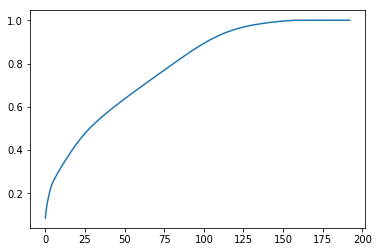

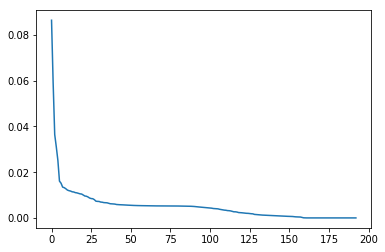

In [34]:
# Investigate the variance accounted for by each principal component.
cul_plt = plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()
individual_var_ratio_plt = plt.plot(pca.explained_variance_ratio_)

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.

# refitting on 75 components
pca = PCA(n_components=75)
pca.fit(azdias_fullinfo_scaled)
pca.explained_variance_ratio_.cumsum()[-1]

azdias_pca = pca.transform(azdias_fullinfo_scaled)



### Discussion 2.2: Perform Dimensionality Reduction

From the culumulative plot above, you can see there is a near linear increase in explained_variance_ratio_ betweeen components 25 and 100, after that the marginal increase starts to go down.

i'm retaining 75 features and this explains 76% of the variability within the data. i think this is a good balance between explanability and compactness of the data. I can revisit this decision depending on the performance of later steps

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def PrintTopXBottomXWeights(component, topk=5):
    component_weights_df = pd.DataFrame(pca.components_, columns=azdias_fullinfo_scaled.columns.values)
    sorted_component_weight = component_weights_df.loc[component].sort_values()
    print('Top {}'.format(topk))
    print(sorted_component_weight[:topk])
    print('Bottom {}:'.format(topk))
    print(sorted_component_weight[-topk:])


In [37]:
PrintTopXBottomXWeights(0, 3)

Top 3
MOBI_REGIO          -0.197577
KBA05_ANTG1         -0.185885
FINANZ_MINIMALIST   -0.182340
Name: 0, dtype: float64
Bottom 3:
WealthType            0.174693
HH_EINKOMMEN_SCORE    0.175287
LP_STATUS_GROB_1      0.185891
Name: 0, dtype: float64


In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PrintTopXBottomXWeights(1, 3)


Top 3
AgeGeneration   -0.235185
FINANZ_SPARER   -0.223159
SEMIO_REL       -0.220556
Name: 1, dtype: float64
Bottom 3:
ZABEOTYP_3              0.199489
FINANZ_VORSORGER        0.212358
ALTERSKATEGORIE_GROB    0.233883
Name: 1, dtype: float64


In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PrintTopXBottomXWeights(2, 3)


Top 3
ANREDE_KZ    -0.332941
SEMIO_KAEM   -0.301971
SEMIO_DOM    -0.268340
Name: 2, dtype: float64
Bottom 3:
SEMIO_SOZ     0.251166
SEMIO_FAM     0.251401
SEMIO_VERT    0.314025
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

The 1st component explains rouhgly 8% of the variability within the data. 
In that component then, MOBI_REGIO is weighted the heaviest, with a negative weighting of -0.19. This feature related to the level of Movement patterns.
the 2nd heaviest weighting is then KBA05_ANTG1, with a negative weighting of -0.185, which is the "Number of 1-2 family houses in the microcell"
and the 3rd is , which is the a measure of Financial typology relating to "low financial interest".

in these cases, the weights a negative, meaning that the correlation of these features compared to the other features is negative.

for the 2nd component, AgeGeneration has the heaviest weighting, and again its negative.
In this case, the 2nd component returns an index that retains most of the variability, when the variability from the 1st component has already been taken into consideration.

for the 3rd component, ANREDE_KZ or Gender has the highest weighting.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [40]:

# Over a number of different cluster counts...
score_list = []
n_cluster_list = [i for i in range(1, 30, 3)]
for i in n_cluster_list:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i).fit(azdias_pca[:100000, :])

    # compute the average within-cluster distances.
    score = kmeans.score(azdias_pca[:100000, :])
    score_list.append(score*-1)

    

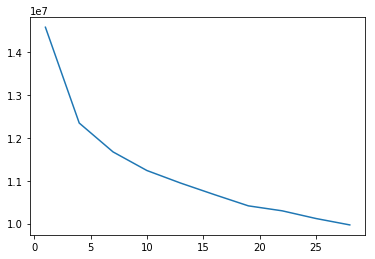

In [41]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots()
ax.plot(n_cluster_list, score_list)


In [42]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=7).fit(azdias_pca)


In [43]:
predictions = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Using the elbow technique, i choose a k value of 7 to fit the kmeans algorithm.
Theres no exact same to get a right answer here, but we could look into the data further to see if we can gain some intuition about what these 7 clusters might represent.

In [44]:
np.unique(predictions, return_counts = True) 

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([ 98063,  90671, 104497,  98408, 113116,  90160,  28294]))

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_scaled = scaler.transform(customers_clean)
customers_pca = pca.transform(customers_scaled)

# customer predictions
customer_predictions = kmeans.predict(customers_pca)


In [47]:
# sense check for any missing data
np.all(customers_clean.isnull().sum() == 0)

True

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

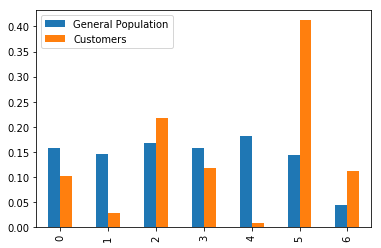

In [48]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
pred_genpop = pd.Series(predictions, name='General Population').value_counts(normalize=True)
pred_cust = pd.Series(customer_predictions, name='Customers').value_counts(normalize=True)

comparison_df = pd.concat([pred_genpop, pred_cust], axis=1)

comparison_df.plot.bar()


In [49]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# people in cluster 5 are over represented in the customer data
# so if we get the cluster centre for cluster 5, reverse out the pca & scaling, to get back to 'original' format data
# this is the representive person for that cluster

reversed_pca_cluster5 = pca.inverse_transform(kmeans.cluster_centers_[5])
reversed_scaling5 = scaler.inverse_transform(reversed_pca_cluster5)
average_cluster5_customer = pd.Series(reversed_scaling5, index=customers_clean.columns)
average_cluster5_customer

# they appear to be an  
    # avantgarde person  (MovementType              0.995279)
    # whos 67 (AgeGeneration            67.576655)
    # 23: Prosperous Households - Families With School Age Children (LifeStage 3.635908, WealthType 2.021667
    # whos equally male and female, with maybe a very small skewed towards male (ANREDE_KR= 1.474955)


ALTERSKATEGORIE_GROB      3.241275
ANREDE_KZ                 1.474450
FINANZ_MINIMALIST         4.512234
FINANZ_SPARER             1.817043
FINANZ_VORSORGER          4.029005
FINANZ_ANLEGER            1.949262
FINANZ_UNAUFFAELLIGER     2.274021
FINANZ_HAUSBAUER          2.015414
GREEN_AVANTGARDE          0.994694
HEALTH_TYP                2.086418
LP_LEBENSPHASE_FEIN      26.015764
LP_LEBENSPHASE_GROB       7.513676
RETOURTYP_BK_S            3.604491
SEMIO_SOZ                 4.186586
SEMIO_FAM                 3.614040
SEMIO_REL                 3.195312
SEMIO_MAT                 3.283930
SEMIO_VERT                4.740743
SEMIO_LUST                5.131724
SEMIO_ERL                 4.985255
SEMIO_KULT                3.747676
SEMIO_RAT                 3.268873
SEMIO_KRIT                4.304616
SEMIO_DOM                 4.662004
SEMIO_KAEM                4.107130
SEMIO_PFLICHT             3.363812
SEMIO_TRADV               3.203394
SOHO_KZ                   0.009681
VERS_TYP            

In [50]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

reversed_pca_cluster2 = pca.inverse_transform(kmeans.cluster_centers_[2])
reversed_scaling2 = scaler.inverse_transform(reversed_pca_cluster2)
average_cluster2_customer = pd.Series(reversed_scaling2, index=customers_clean.columns)
average_cluster2_customer



# they appear to be an  
    # mainstream person  (MovementType              0.051038)
    # who was born in the late 80s (AgeGeneration            87.773032)
    # 42: Less Affluent Households - Young Couples With Children (LifeStage 2.026593, WealthType 4.409292)
    # whos slightly more female (ANREDE_KR= 1.582445)


ALTERSKATEGORIE_GROB      3.384978
ANREDE_KZ                 1.488965
FINANZ_MINIMALIST         4.304677
FINANZ_SPARER             1.720503
FINANZ_VORSORGER          4.207541
FINANZ_ANLEGER            2.517112
FINANZ_UNAUFFAELLIGER     1.783112
FINANZ_HAUSBAUER          2.416634
GREEN_AVANTGARDE          0.010116
HEALTH_TYP                2.175045
LP_LEBENSPHASE_FEIN      20.665365
LP_LEBENSPHASE_GROB       6.117275
RETOURTYP_BK_S            3.633982
SEMIO_SOZ                 3.820814
SEMIO_FAM                 3.470801
SEMIO_REL                 3.040922
SEMIO_MAT                 2.950346
SEMIO_VERT                4.402687
SEMIO_LUST                5.063850
SEMIO_ERL                 5.306649
SEMIO_KULT                3.624036
SEMIO_RAT                 3.084848
SEMIO_KRIT                4.599190
SEMIO_DOM                 4.273979
SEMIO_KAEM                3.954481
SEMIO_PFLICHT             3.188663
SEMIO_TRADV               2.796155
SOHO_KZ                   0.011611
VERS_TYP            

### Discussion 3.3: Compare Customer Data to Demographics Data

The clustering analysis demonstrated that the demographics of the customers are not very well matched to the general demographics of the population.

When we clustered the population into 7 different groups, we found that the distribution of customers into these 7 groups was very different that the distribution of the general population

For example, there was one cluster that is just 15% of the population, but it makes up more than 35% of te customer base.

This 15% of the population is therefore relatively popular with the mail-order company.

There are generally:
    * avantgarde type person
    * born in the late 60s
    * From a Prosperous Household, within a family of School Age Children
    
Another segment of the population that represents nearly 20% of the general population, makes up less than 1% of the customer base.

People from this segment are generally:
    * mainstream person
    * who was born in the late 80s
    * from a Less Affluent Household, that has contains Young Couples With Children
    * and they skew slightly female
    
Further analysis could be performed to determine what segment/cluster is best to focus on to improve future sales.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.